CODE BLOCK: 1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [127]:
# CUDA?
# cuda = torch.cuda.is_available()
# print("CUDA Available?", cuda)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


CODE BLOCK: 3

In [133]:
# Optimized train data transformations for CIFAR-10
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the images on the horizontal axis
    # transforms.RandomCrop(32, padding=2),  # Apply random crops to the images with padding
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Slight color jitter
    transforms.RandomRotation(7),  # Randomly rotate images within the specified angle range
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # Normalize the images
])

# Optimized test data transformations for CIFAR-10
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

CODE BLOCK: 4

In [134]:
train_data = datasets.CIFAR10('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('../data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


CODE BLOCK: 5

In [135]:
batch_size = 128

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

len(train_loader)

391

CODE BLOCK: 6

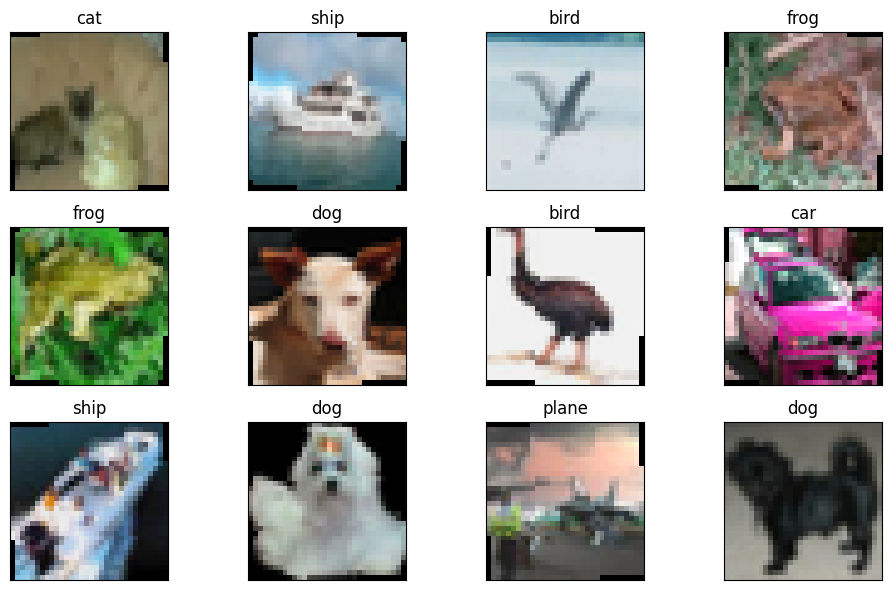

In [136]:
import matplotlib.pyplot as plt
import numpy as np

batch_data, batch_label = next(iter(train_loader))

# Define the class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

fig = plt.figure(figsize=(10, 6))

for i in range(12):
  ax = plt.subplot(3,4,i+1)
  ax.imshow(np.transpose(batch_data[i].numpy(), (1, 2, 0)))
  ax.set_title(classes[batch_label[i]])
  plt.xticks([])
  plt.yticks([])

plt.tight_layout()

In [149]:
import torch.nn as nn
import torch.nn.functional as F

class CIFAR10Net3Optimized(nn.Module):
    def __init__(self, dropout_value=0.05, num_groups=4):
        super(CIFAR10Net3Optimized, self).__init__()

        # C1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.GroupNorm(num_groups, 8),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        # C2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.GroupNorm(num_groups, 16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        # c3 & P1
        self.transblock1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.MaxPool2d(2, 2)
        )

        # C4
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.GroupNorm(num_groups, 16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        # C5
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.GroupNorm(num_groups, 32),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        # C6
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.GroupNorm(num_groups, 32),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        # c7 & P2
        self.transblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.MaxPool2d(2, 2)
        )

        # C8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.GroupNorm(num_groups, 32),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        # C9
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.GroupNorm(num_groups, 32),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        # C10
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.GroupNorm(num_groups, 32),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        # GAP
        self.gap = nn.AdaptiveAvgPool2d(1)

        # FC Layer
        self.fc = nn.Linear(32, 10)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.transblock1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.transblock2(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [150]:
model = CIFAR10Net3Optimized().to(device)

In [151]:
from torchsummary import summary
summary(model,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
         GroupNorm-2            [-1, 8, 32, 32]              16
              ReLU-3            [-1, 8, 32, 32]               0
           Dropout-4            [-1, 8, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           1,152
         GroupNorm-6           [-1, 16, 32, 32]              32
              ReLU-7           [-1, 16, 32, 32]               0
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9            [-1, 8, 32, 32]             128
        MaxPool2d-10            [-1, 8, 16, 16]               0
           Conv2d-11           [-1, 16, 16, 16]           1,152
        GroupNorm-12           [-1, 16, 16, 16]              32
             ReLU-13           [-1, 16, 16, 16]               0
          Dropout-14           [-1, 16,

CODE BLOCK: 8

In [ ]:
# Data to plot accuracy and loss graphs
# train_losses = []
# test_losses = []
# train_acc = []
# test_acc = []

# test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [152]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.cross_entropy(y_pred, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc=f'Epoch: {epoch} Loss={loss.item():.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:.2f}%')

    train_losses.append(train_loss / len(train_loader))
    train_acc.append(100 * correct / processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_acc.append(100. * correct / len(test_loader.dataset))

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.2f}%)')

CODE BLOCK: 10

In [154]:
from torch.optim.lr_scheduler import StepLR

# model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Epoch: 0 Loss=1.1631 Batch_id=390 Accuracy=56.24%: 100%|██████████| 391/391 [00:39<00:00,  9.79it/s]



Test set: Average loss: 1.1537, Accuracy: 5849/10000 (58.49%)
EPOCH: 1


Epoch: 1 Loss=1.2432 Batch_id=390 Accuracy=56.29%: 100%|██████████| 391/391 [00:39<00:00, 10.00it/s]



Test set: Average loss: 1.2314, Accuracy: 5546/10000 (55.46%)
EPOCH: 2


Epoch: 2 Loss=1.1712 Batch_id=390 Accuracy=56.55%: 100%|██████████| 391/391 [00:39<00:00,  9.95it/s]



Test set: Average loss: 1.1847, Accuracy: 5712/10000 (57.12%)
EPOCH: 3


Epoch: 3 Loss=1.2286 Batch_id=390 Accuracy=57.10%: 100%|██████████| 391/391 [00:39<00:00,  9.93it/s]



Test set: Average loss: 1.1526, Accuracy: 5875/10000 (58.75%)
EPOCH: 4


Epoch: 4 Loss=1.0671 Batch_id=390 Accuracy=57.27%: 100%|██████████| 391/391 [00:39<00:00,  9.89it/s]



Test set: Average loss: 1.1752, Accuracy: 5762/10000 (57.62%)
EPOCH: 5


Epoch: 5 Loss=1.0976 Batch_id=390 Accuracy=57.63%: 100%|██████████| 391/391 [00:39<00:00,  9.90it/s]



Test set: Average loss: 1.1270, Accuracy: 5949/10000 (59.49%)
EPOCH: 6


Epoch: 6 Loss=1.0618 Batch_id=390 Accuracy=58.72%: 100%|██████████| 391/391 [00:39<00:00,  9.85it/s]



Test set: Average loss: 1.1294, Accuracy: 5946/10000 (59.46%)
EPOCH: 7


Epoch: 7 Loss=1.1595 Batch_id=390 Accuracy=58.97%: 100%|██████████| 391/391 [00:39<00:00,  9.83it/s]



Test set: Average loss: 1.1396, Accuracy: 5897/10000 (58.97%)
EPOCH: 8


Epoch: 8 Loss=0.9442 Batch_id=390 Accuracy=58.94%: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]



Test set: Average loss: 1.1188, Accuracy: 5974/10000 (59.74%)
EPOCH: 9


Epoch: 9 Loss=1.1019 Batch_id=390 Accuracy=58.89%: 100%|██████████| 391/391 [00:39<00:00,  9.93it/s]



Test set: Average loss: 1.1366, Accuracy: 5914/10000 (59.14%)
EPOCH: 10


Epoch: 10 Loss=1.0749 Batch_id=390 Accuracy=58.65%: 100%|██████████| 391/391 [00:39<00:00,  9.93it/s]



Test set: Average loss: 1.1219, Accuracy: 5965/10000 (59.65%)
EPOCH: 11


Epoch: 11 Loss=1.0664 Batch_id=390 Accuracy=59.04%: 100%|██████████| 391/391 [00:39<00:00,  9.84it/s]



Test set: Average loss: 1.1227, Accuracy: 5927/10000 (59.27%)
EPOCH: 12


Epoch: 12 Loss=1.0824 Batch_id=390 Accuracy=58.98%: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s]



Test set: Average loss: 1.1250, Accuracy: 5931/10000 (59.31%)
EPOCH: 13


Epoch: 13 Loss=1.1700 Batch_id=390 Accuracy=58.99%: 100%|██████████| 391/391 [00:39<00:00, 10.02it/s]



Test set: Average loss: 1.1240, Accuracy: 5956/10000 (59.56%)
EPOCH: 14


Epoch: 14 Loss=1.1650 Batch_id=390 Accuracy=59.25%: 100%|██████████| 391/391 [00:39<00:00,  9.88it/s]



Test set: Average loss: 1.1233, Accuracy: 5950/10000 (59.50%)
EPOCH: 15


Epoch: 15 Loss=1.1175 Batch_id=390 Accuracy=59.14%: 100%|██████████| 391/391 [00:39<00:00,  9.79it/s]



Test set: Average loss: 1.1234, Accuracy: 5941/10000 (59.41%)
EPOCH: 16


Epoch: 16 Loss=1.4194 Batch_id=390 Accuracy=59.22%: 100%|██████████| 391/391 [00:39<00:00,  9.87it/s]



Test set: Average loss: 1.1217, Accuracy: 5946/10000 (59.46%)
EPOCH: 17


Epoch: 17 Loss=1.4112 Batch_id=390 Accuracy=59.06%: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s]



Test set: Average loss: 1.1224, Accuracy: 5937/10000 (59.37%)
EPOCH: 18


Epoch: 18 Loss=1.1753 Batch_id=390 Accuracy=58.95%: 100%|██████████| 391/391 [00:41<00:00,  9.50it/s]



Test set: Average loss: 1.1238, Accuracy: 5939/10000 (59.39%)
EPOCH: 19


Epoch: 19 Loss=1.1480 Batch_id=390 Accuracy=59.30%: 100%|██████████| 391/391 [00:39<00:00,  9.79it/s]



Test set: Average loss: 1.1246, Accuracy: 5937/10000 (59.37%)


CODE BLOCK: 11

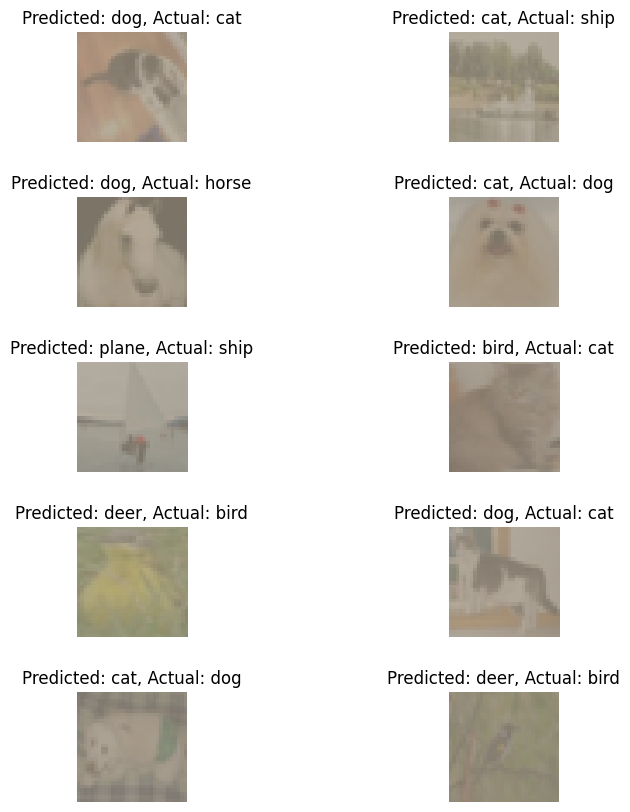

In [155]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def get_misclassified_images(model, device, test_loader):
    model.eval()
    misclassified = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            idxs_mask = ~pred.eq(target.view_as(pred)).view(-1)
            misclassified.extend([(data[i], pred[i], target[i]) for i in range(len(idxs_mask)) if idxs_mask[i]])
            if len(misclassified) >= 10:
                break
    return misclassified[:10]

# Assuming 'model', 'device', and 'test_loader' are already defined and initialized
misclassified_images = get_misclassified_images(model, device, test_loader)

# Plotting the misclassified images
fig, axes = plt.subplots(5, 2, figsize=(8, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, (img, pred, target) in enumerate(misclassified_images):
    img, pred, target = img.cpu().numpy(), pred.cpu(), target.cpu()
    ax = axes[i//2, i%2]
    img = img.transpose((1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img = img * std + mean  # De-normalize
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(f'Predicted: {classes[pred.item()]}, Actual: {classes[target.item()]}')
    ax.axis('off')

plt.show()